In [1]:
#drive.flush_and_unmount()

In [2]:
# Import Data from Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import Libraries
import pandas as pd # Data analysis and manipulation tool
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay # Import essential metrics to evaluate
from sklearn.model_selection import train_test_split
import xgboost #Using XGBClassifier to do classify task, there also XGBRegression to do predict task
import matplotlib.pyplot as plt # Use for creating chart
import seaborn as sns # Use with matplotlib to visualize
import warnings # Suppress Warning

In [4]:
# Suppress Future Warning
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
'''
Read dataset from Drive
Using pandas to read parquet files because the dataset are using .parquet extension
There are 2 dataset, one for SQL and another for NoSQL.
'''
df_NoSQLi = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Database Injection/NoSQLi_feature.parquet')
df_SQLi = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Database Injection/SQLi_feature.parquet')

# Show statistics of dataset. Using .shape property, it shows (total of records (Row), total of Columns)
df_NoSQLi.shape , df_SQLi.shape

((400, 54), (30919, 52))

In [6]:
# Remove unnessary columns
df_SQLi.drop(columns=['Query'], inplace=True)
df_NoSQLi.drop(columns=['text'], inplace=True)

# Declear a variable to not conflict with function parameter
dep = 'label'

In [7]:
# Show what columns is in the dataset
df_SQLi.columns, df_NoSQLi.columns

(Index(['Query Length', 'Number of Words', 'Number of Special Characters',
        'Number of SQL Keywords', 'Presence of UNION', 'Presence of SELECT',
        'Presence of FROM', 'Presence of OR', 'Presence of AND',
        'Presence of INSERT', 'Presence of DROP', 'Presence of TABLE',
        'Presence of WHERE', 'Presence of GROUP BY', 'Presence of HAVING',
        'Presence of LIMIT', 'Presence of ORDER BY', 'Number of Parentheses',
        'Presence of /*', 'Presence of --', 'Presence of sleep',
        'Presence of load_file', 'Presence of subselect', 'Presence of ASCII',
        'Presence of database', 'Number of = 1', 'Number of Comments',
        'Number of Subqueries', 'Presence of version',
        'Presence of information_schema', 'Use of sleep with time',
        'Presence of hex encoded values', 'Presence of ASCII operations',
        'Presence of SQL functions', 'Presence of user', 'Presence of password',
        'Number of 1 literals', 'Number of LIKE clauses',
        

In [8]:
df_NoSQLi['label'].value_counts(), df_SQLi['label'].value_counts()

(label
 1    222
 0    178
 Name: count, dtype: int64,
 label
 0    19537
 1    11382
 Name: count, dtype: int64)

In [9]:
# Split data to Traing:80, Test:20
df_NoSQLi_train, df_NoSQLi_test = train_test_split(df_NoSQLi, test_size=0.2, random_state=18)
df_SQLi_train, df_SQLi_test = train_test_split(df_SQLi, test_size=0.2, random_state=18)

In [10]:
df_NoSQLi_train.shape, df_NoSQLi_test.shape

((320, 53), (80, 53))

In [11]:
df_SQLi_train.shape, df_SQLi_test.shape

((24735, 51), (6184, 51))

In [12]:
# Show total of Benign and Malicious in Train and Test for SQL
df_SQLi_train['label'].value_counts(), df_SQLi_test['label'].value_counts()

(label
 0    15615
 1     9120
 Name: count, dtype: int64,
 label
 0    3922
 1    2262
 Name: count, dtype: int64)

In [13]:
# Show total of Benign and Malicious in Train and Test for SQL
df_NoSQLi_train['label'].value_counts(), df_NoSQLi_test['label'].value_counts()

(label
 1    177
 0    143
 Name: count, dtype: int64,
 label
 1    45
 0    35
 Name: count, dtype: int64)

In [14]:
'''
Utility Function to Extract Feature(X) and Label(Y) from Dataset
Feature: all columns except class
Label: Class columns, used as a target to classify
'''
def xs_y(df_, targ):
    '''
    Allow Targ (Label) to be List or Single value
    xs: Copy all columns that not targ
    '''
    if not isinstance(targ, list):
        xs = df_[df_.columns.difference([targ])].copy()
    else:
        xs = df_[df_.columns.difference(targ)].copy()
    # Copy targ to y
    y = df_[targ].copy()
    # Return Features and Label
    return xs, y

In [15]:
# Split train and test to Xs and Y for SQLi
SQLi_X_train, SQLi_y_train = xs_y(df_SQLi_train, dep)
SQLi_X_test, SQLi_y_test = xs_y(df_SQLi_test, dep)
SQLi_X_train.shape, SQLi_y_train.shape, SQLi_X_test.shape, SQLi_y_test.shape

((24735, 50), (24735,), (6184, 50), (6184,))

In [16]:
# Split train and test to Xs and Y for NoSQLi
NoSQLi_X_train, NoSQLi_y_train = xs_y(df_NoSQLi_train, dep)
NoSQLi_X_test, NoSQLi_y_test = xs_y(df_NoSQLi_test, dep)
NoSQLi_X_train.shape, NoSQLi_y_train.shape, NoSQLi_X_test.shape, NoSQLi_y_test.shape

((320, 52), (320,), (80, 52), (80,))

# SQLi Training

In [17]:
# Define XGBoost Classifier Hyperparameter: Not Optimized
SQLi_xgb = xgboost.XGBClassifier(
        n_estimators= 100, # 100 boosting rounds, in this case it is 100 Decision Trees
        max_depth= 8, # When Decision Tree reach 8 depths, It will begin Prune process
        booster= 'gbtree', # Use Decision tree as Weak Learner
        subsample= 0.5, # Take a part (50%) of Training for each Tree
        colsample_bytree= 0.5, # Take a part (50%) of Feature for each Tree
        importance_type= 'gain', # Choose Gain metric to evaluate Feature Importance
        objective='binary:logistic', # Objective of the task is Classification, so Binary Classification with Logistic Regression
        eval_metric='logloss', # Use 'logloss' as a metric to evaluate model in Training
    )

Iteration 0: Train Logloss: 0.43262, Test Logloss: 0.4311
Iteration 10: Train Logloss: 0.04198, Test Logloss: 0.04335
Iteration 20: Train Logloss: 0.01656, Test Logloss: 0.01833
Iteration 30: Train Logloss: 0.01265, Test Logloss: 0.01439
Iteration 40: Train Logloss: 0.01074, Test Logloss: 0.01265
Iteration 50: Train Logloss: 0.00979, Test Logloss: 0.01142
Iteration 60: Train Logloss: 0.00931, Test Logloss: 0.01094
Iteration 70: Train Logloss: 0.00901, Test Logloss: 0.01061
Iteration 80: Train Logloss: 0.0087, Test Logloss: 0.01048
Iteration 90: Train Logloss: 0.00853, Test Logloss: 0.01036


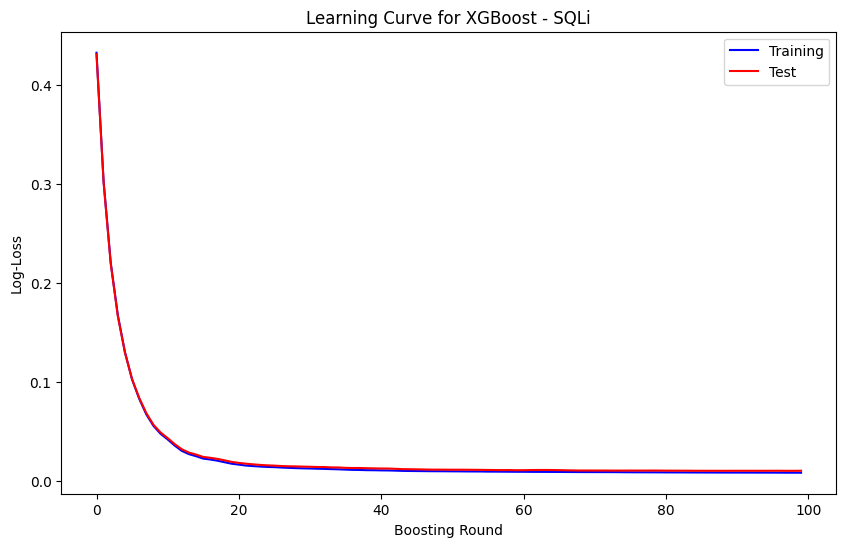

In [18]:
SQLi_xgb.fit(
    SQLi_X_train, SQLi_y_train,
    eval_set=[(SQLi_X_train, SQLi_y_train), (SQLi_X_test, SQLi_y_test)],  # Monitor training and test sets
    verbose = False, # Prevent it make output
)

result = SQLi_xgb.evals_result() # Get the Evalution Result

# Extract log-loss values
train_logloss = result['validation_0']['logloss']
test_logloss = result['validation_1']['logloss']

# Print log-loss for every 10th iteration
for i in range(0, len(train_logloss), 10):
    print(f"Iteration {i}: Train Logloss: {round(train_logloss[i],5)}, Test Logloss: {round(test_logloss[i],5)}")

# Plot the Learning Curve based on Logarith Loss metric
plt.figure(figsize=(10, 6))
plt.plot(result['validation_0']['logloss'], label='Training', color='blue')
plt.plot(result['validation_1']['logloss'], label='Test', color='red')
plt.xlabel('Boosting Round')
plt.ylabel('Log-Loss')
plt.title('Learning Curve for XGBoost - SQLi')
plt.legend(loc='upper right')
plt.show()

In [19]:
# Classify the test set
SQLi_xgb_preds = SQLi_xgb.predict(SQLi_X_test)

In [20]:
'''
Define DataFrame for the Test classification
Auroc: Area Under the Curve of Receiver Operating Characteristic (ROC)
Accuracy: Accuracy of the classification
Precision: Precision of the classification
Recall: Recall of the classification
F1: F1 Score of the classification
'''
noopt_df = pd.DataFrame(data=[[
        'nslkdd-binary',
        'xgb-no-opt',
        SQLi_X_train.shape,
        SQLi_X_test.shape,
        round(accuracy_score(y_true=SQLi_y_test, y_pred=SQLi_xgb_preds), 4),
        round(precision_score(y_true=SQLi_y_test, y_pred=SQLi_xgb_preds), 4),
        round(recall_score(y_true=SQLi_y_test, y_pred=SQLi_xgb_preds), 4),
        round(f1_score(y_true=SQLi_y_test, y_pred=SQLi_xgb_preds), 4)
    ]], columns=['AtkCls', 'model', 'TrainShape', 'TestShape', 'Accuracy', 'Precision', 'Recall', 'F1'])
# Show the DataFrame
noopt_df

,AtkCls,model,TrainShape,TestShape,Accuracy,Precision,Recall,F1
0,nslkdd-binary,xgb-no-opt,"(24735, 50)","(6184, 50)",0.9969,0.9978,0.9938,0.9958


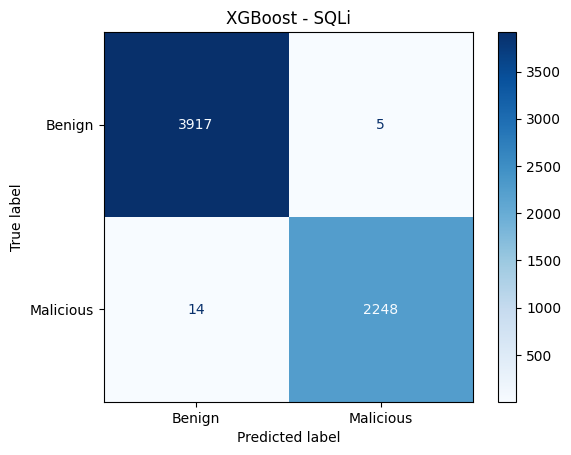

In [21]:
# Define the Confusion Matrix
cm = confusion_matrix(SQLi_y_test, SQLi_xgb_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malicious'])
disp.plot(cmap='Blues')
disp.ax_.set_title("XGBoost - SQLi")
plt.show()

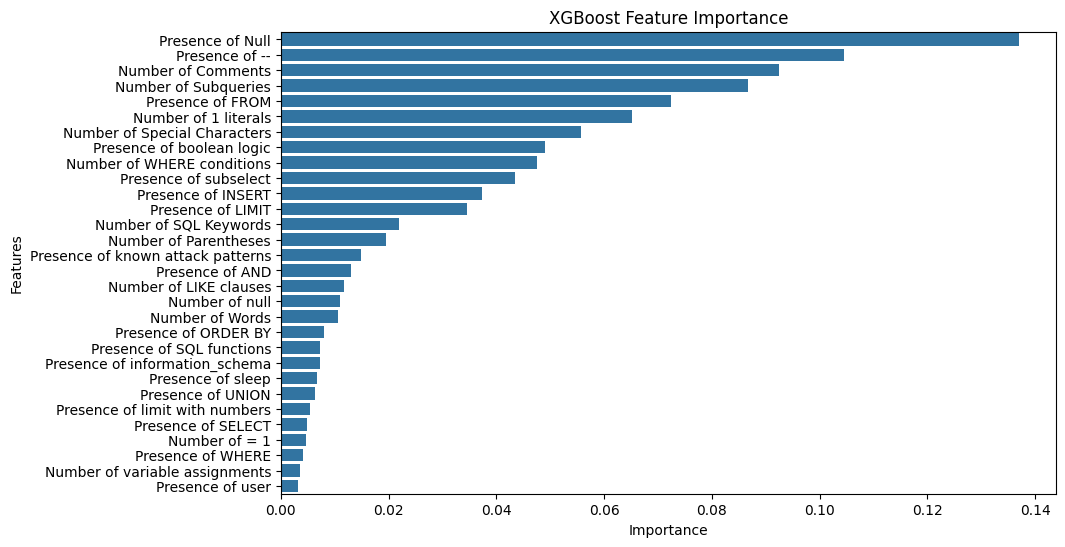

In [22]:
feature_importances = pd.DataFrame(SQLi_xgb.feature_importances_,
                                   index = SQLi_X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

top_20_features = feature_importances.head(30)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_20_features['importance'], y=top_20_features.index)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [23]:
SQLi_xgb.save_model("/content/drive/MyDrive/Colab Notebooks/model/SQLi_model.bin")  # Save the model

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:05:36] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


# NoSQLi Training

In [24]:
NoSQLi_xgb = xgboost.XGBClassifier(
        n_estimators= 100, # 100 boosting rounds, in this case it is 100 Decision Trees
        max_depth= 8, # When Decision Tree reach 8 depths, It will begin Prune process
        booster= 'gbtree', # Use Decision tree as Weak Learner
        subsample= 0.5, # Take a part (50%) of Training for each Tree
        colsample_bytree= 0.5, # Take a part (50%) of Feature for each Tree
        importance_type= 'gain', # Choose Gain metric to evaluate Feature Importance
        objective='binary:logistic', # Objective of the task is Classification, so Binary Classification with Logistic Regression
        eval_metric='logloss', # Use 'logloss' as a metric to evaluate model in Training
    )

Iteration 0: Train Logloss: 0.61369, Test Logloss: 0.63947
Iteration 10: Train Logloss: 0.362, Test Logloss: 0.49157
Iteration 20: Train Logloss: 0.29466, Test Logloss: 0.45282
Iteration 30: Train Logloss: 0.26037, Test Logloss: 0.46065
Iteration 40: Train Logloss: 0.2409, Test Logloss: 0.44356
Iteration 50: Train Logloss: 0.2225, Test Logloss: 0.43219
Iteration 60: Train Logloss: 0.20973, Test Logloss: 0.41436
Iteration 70: Train Logloss: 0.19866, Test Logloss: 0.41427
Iteration 80: Train Logloss: 0.19156, Test Logloss: 0.42771
Iteration 90: Train Logloss: 0.18337, Test Logloss: 0.43429


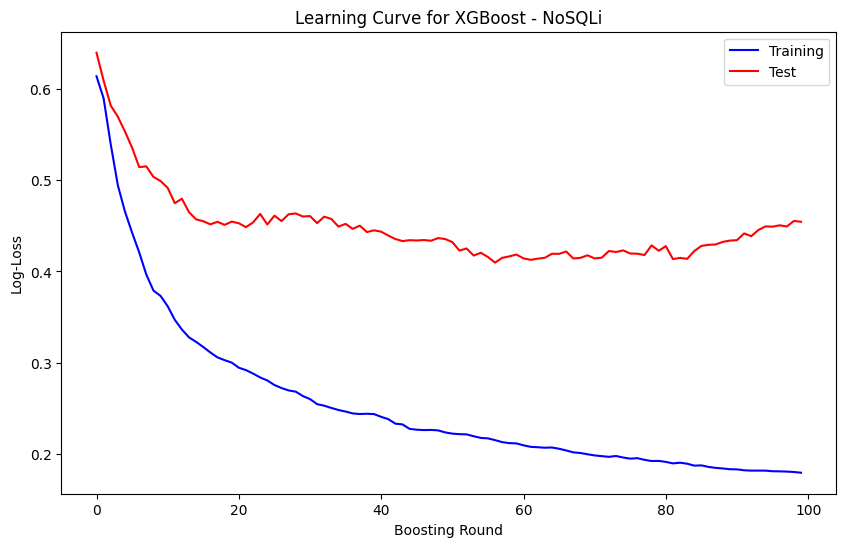

In [25]:
NoSQLi_xgb.fit(
    NoSQLi_X_train, NoSQLi_y_train,
    eval_set=[(NoSQLi_X_train, NoSQLi_y_train), (NoSQLi_X_test, NoSQLi_y_test)],  # Monitor training and test sets
    verbose = False, # Prevent it make output
)

result = NoSQLi_xgb.evals_result() # Get the Evalution Result

# Extract log-loss values
train_logloss = result['validation_0']['logloss']
test_logloss = result['validation_1']['logloss']

# Print log-loss for every 10th iteration
for i in range(0, len(train_logloss), 10):
    print(f"Iteration {i}: Train Logloss: {round(train_logloss[i],5)}, Test Logloss: {round(test_logloss[i],5)}")

# Plot the Learning Curve based on Logarith Loss metric
plt.figure(figsize=(10, 6))
plt.plot(result['validation_0']['logloss'], label='Training', color='blue')
plt.plot(result['validation_1']['logloss'], label='Test', color='red')
plt.xlabel('Boosting Round')
plt.ylabel('Log-Loss')
plt.title('Learning Curve for XGBoost - NoSQLi')
plt.legend(loc='upper right')
plt.show()

In [26]:
# Classify the test set
NoSQLi_xgb_preds = NoSQLi_xgb.predict(NoSQLi_X_test)

In [27]:
'''
Define DataFrame for the Test classification
Auroc: Area Under the Curve of Receiver Operating Characteristic (ROC)
Accuracy: Accuracy of the classification
Precision: Precision of the classification
Recall: Recall of the classification
F1: F1 Score of the classification
'''
noopt_df = pd.DataFrame(data=[[
        'nslkdd-binary',
        'xgb-no-opt',
        NoSQLi_X_train.shape,
        NoSQLi_X_test.shape,
        round(accuracy_score(y_true=NoSQLi_y_test, y_pred=NoSQLi_xgb_preds), 4),
        round(precision_score(y_true=NoSQLi_y_test, y_pred=NoSQLi_xgb_preds), 4),
        round(recall_score(y_true=NoSQLi_y_test, y_pred=NoSQLi_xgb_preds), 4),
        round(f1_score(y_true=NoSQLi_y_test, y_pred=NoSQLi_xgb_preds), 4)
    ]], columns=['AtkCls', 'model', 'TrainShape', 'TestShape', 'Accuracy', 'Precision', 'Recall', 'F1'])
# Show the DataFrame
noopt_df

,AtkCls,model,TrainShape,TestShape,Accuracy,Precision,Recall,F1
0,nslkdd-binary,xgb-no-opt,"(320, 52)","(80, 52)",0.825,0.8163,0.8889,0.8511


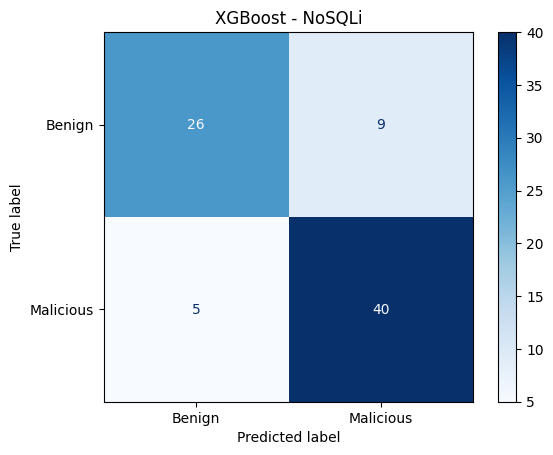

In [28]:
# Define the Confusion Matrix
cm = confusion_matrix(NoSQLi_y_test, NoSQLi_xgb_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malicious'])
disp.plot(cmap='Blues')
disp.ax_.set_title("XGBoost - NoSQLi")
plt.show()

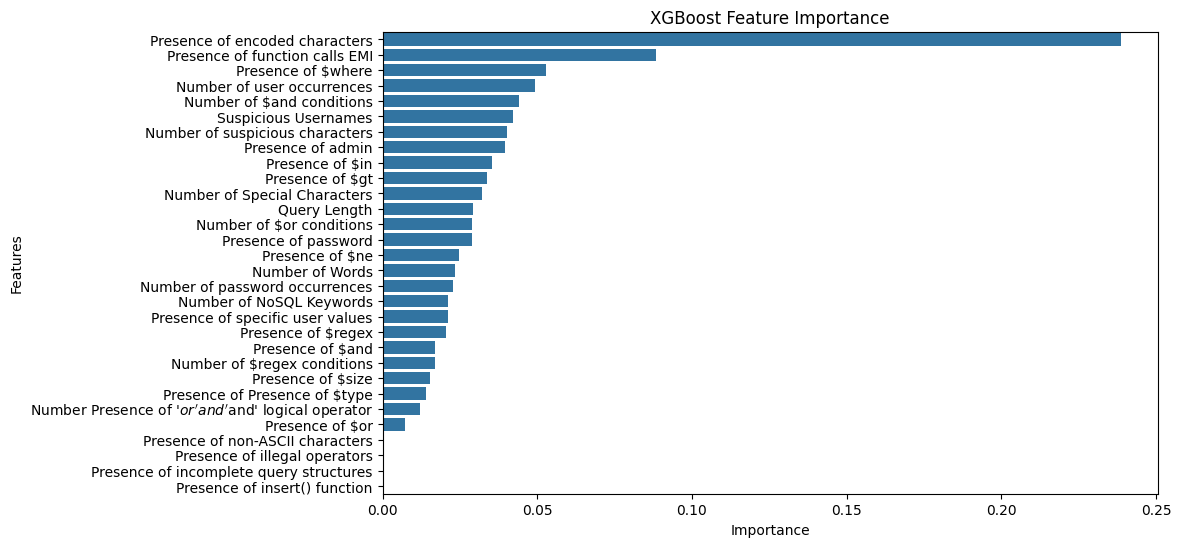

In [29]:
feature_importances = pd.DataFrame(NoSQLi_xgb.feature_importances_,
                                   index = NoSQLi_X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

top_20_features = feature_importances.head(30)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_20_features['importance'], y=top_20_features.index)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [30]:
NoSQLi_xgb.save_model("/content/drive/MyDrive/Colab Notebooks/model/NoSQLi_model.bin")  # Save the model

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:05:37] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


# Application

In [31]:
def extract_SQL_features(query):

    query_features = []

    # 1. Query Length
    query_features.append(len(query))

    # 2. Number of Words
    query_features.append(len(query.split()))

    # 3. Number of Special Characters
    special_chars = re.findall(r'[\!@#$%^&*()_+=\-<>?/\|\\:;"\'{}[\]]', query)
    query_features.append(len(special_chars))

    # 4. Number of SQL Keywords
    sql_keywords = ['select', 'insert', 'update', 'delete', 'drop', 'union', 'exist', 'where', 'and', 'or', 'from', 'create']
    keyword_count = sum([query.lower().count(keyword) for keyword in sql_keywords])
    query_features.append(keyword_count)

    # 5. Presence of 'UNION'
    query_features.append(int('union' in query.lower()))

    # 6. Presence of 'SELECT'
    query_features.append(int('select' in query.lower()))

    # 7. Presence of 'FROM'
    query_features.append(int('from' in query.lower()))

    # 8. Presence of 'OR'
    query_features.append(int('or' in query.lower()))

    # 9. Presence of 'AND'
    query_features.append(int('and' in query.lower()))

    # 10. Presence of 'INSERT'
    query_features.append(int('insert' in query.lower()))

    # 11. Presence of 'DROP'
    query_features.append(int('drop' in query.lower()))

    # 12. Presence of 'TABLE'
    query_features.append(int('table' in query.lower()))

    # 13. Presence of 'WHERE'
    query_features.append(int('where' in query.lower()))

    # 14. Presence of 'GROUP BY'
    query_features.append(int('group by' in query.lower()))

    # 15. Presence of 'HAVING'
    query_features.append(int('having' in query.lower()))

    # 16. Presence of 'LIMIT'
    query_features.append(int('limit' in query.lower()))

    # 17. Presence of 'ORDER BY'
    query_features.append(int('order by' in query.lower()))

    # 18. Number of Parentheses
    query_features.append(query.count('(') + query.count(')'))

    # 19. Presence of '/*'
    query_features.append(int('/*' in query))

    # 20. Presence of '--'
    query_features.append(int('--' in query))

    # 21. Presence of 'sleep'
    query_features.append(int('sleep' in query.lower()))

    # 22. Presence of 'load_file'
    query_features.append(int('load_file' in query.lower()))

    # 23. Presence of 'subselect'
    query_features.append(int('select' in query.lower() and '(' in query))

    # 24. Presence of 'ASCII'
    query_features.append(int('ascii' in query.lower()))

    # 25. Presence of 'database'
    query_features.append(int('database' in query.lower()))

    # 26. Number of = 1
    query_features.append(query.count('= 1'))

    # 27. Number of Comments
    query_features.append(query.count('--') + query.count('/*'))

    # 28. Number of Subqueries
    query_features.append(query.count('select') - query.count('union'))

    # 29. Presence of 'version'
    query_features.append(int('version' in query.lower()))

    # 30. Presence of 'information_schema'
    query_features.append(int('information_schema' in query.lower()))

    # 31. Use of 'sleep' with time
    query_features.append(int('sleep' in query.lower() and 'time' in query.lower()))

    # 32. Presence of 'hex' encoded values
    query_features.append(int('hex' in query.lower()))

    # 33. Presence of 'ASCII' operations
    query_features.append(int('ascii' in query.lower()))

    # 34. Presence of SQL functions (e.g., 'substring', 'top', etc.)
    sql_functions = ['substring', 'top', 'concat', 'left', 'right']
    query_features.append(int(any(func in query.lower() for func in sql_functions)))

    # 35. Presence of 'user'
    query_features.append(int('user' in query.lower()))

    # 36. Presence of 'password'
    query_features.append(int('password' in query.lower()))

    # 37. Number of '1' literals
    query_features.append(query.count('1'))

    # 38. Number of LIKE clauses
    query_features.append(query.lower().count('like'))

    # 39. Presence of 'char' function
    query_features.append(int('char(' in query.lower()))

    # 40. Presence of 'limit' with numbers
    query_features.append(int('limit' in query.lower() and any(c.isdigit() for c in query)))

    # 41. Query Contains null Union Clauses
    query_features.append(int('null' in query.lower()))

    # 42. Number of null
    query_features.append(query.lower().count('null'))

    # 43. Number of WHERE conditions
    query_features.append(query.lower().count('where'))

    # 44. Presence of boolean logic ('= 1' or 'OR 1=1')
    query_features.append(int('= 1' in query.lower() or 'or 1=1' in query.lower()))

    # 45. Number of variable assignments
    query_features.append(query.count('@'))

    # 46. Presence of system functions (@@version, sys.objects, etc.)
    system_functions = ['@@version', 'sys.objects']
    query_features.append(int(any(func in query.lower() for func in system_functions)))

    # 47. Presence of 'delete' delay functions
    query_features.append(int('delete' in query.lower()))

    # 48. Number of errors
    query_features.append(int('error' in query.lower()))

    # 49. Number of common attack phrases
    attack_phrases = ['or 1=1', 'union select', 'drop table']
    query_features.append(sum(query.lower().count(phrase) for phrase in attack_phrases))

    # 50. Presence of known attack patterns
    known_attack_patterns = ['--', '/*', 'select * from', 'union', 'drop']
    query_features.append(int(any(pattern in query.lower() for pattern in known_attack_patterns)))

    query_features = [query_features]

    feature_names = ['Query Length', 'Number of Words', 'Number of Special Characters', 'Number of SQL Keywords', 'Presence of UNION',
                 'Presence of SELECT', 'Presence of FROM', 'Presence of OR', 'Presence of AND', 'Presence of INSERT',
                 'Presence of DROP', 'Presence of TABLE', 'Presence of WHERE', 'Presence of GROUP BY', 'Presence of HAVING',
                 'Presence of LIMIT', 'Presence of ORDER BY', 'Number of Parentheses', 'Presence of /*', 'Presence of --',
                 'Presence of sleep', 'Presence of load_file', 'Presence of subselect', 'Presence of ASCII', 'Presence of database',
                 'Number of = 1', 'Number of Comments', 'Number of Subqueries', 'Presence of version', 'Presence of information_schema',
                 'Use of sleep with time', 'Presence of hex encoded values', 'Presence of ASCII operations', 'Presence of SQL functions',
                 'Presence of user', 'Presence of password', 'Number of 1 literals', 'Number of LIKE clauses', 'Presence of char function',
                 'Presence of limit with numbers', 'Presence of Null', 'Number of null', 'Number of WHERE conditions',
                 'Presence of boolean logic', 'Number of variable assignments', 'Presence of system functions', 'Presence of delete',
                 'Number of errors', 'Number of common attack phrases', 'Presence of known attack patterns']

    # Create DataFrame with original feature order
    df = pd.DataFrame(query_features, columns=feature_names)

    # Sort columns based on feature_names order
    df = df.reindex(sorted(df.columns), axis=1)

    return df

In [32]:
def extract_NoSQL_feature(query):

    query_features = []

    # 1. Query Length
    query_features.append(len(query))

    # 2. Number of Words
    query_features.append(len(query.split()))

    # 3. Number of Special Characters
    special_chars = re.findall(r'[\!@#$%^&*()_+=\-<>?/\|\\:;"\'{}[\]]', query)
    query_features.append(len(special_chars))

    # 4. Number of NoSQL Keywords
    nosql_keywords = ['$regex', '$ne', '$gt', '$lt', '$in', '$or', '$and', '$where', '$exists', '$mod']
    keyword_count = sum([query.lower().count(keyword) for keyword in nosql_keywords])
    query_features.append(keyword_count)

    # 5. Presence of '$regex'
    query_features.append(int('$regex' in query.lower()))

    # 6. Presence of '$ne'
    query_features.append(int('$ne' in query.lower()))

    # 7. Presence of '$gt'
    query_features.append(int('$gt' in query.lower()))

    # 8. Presence of '$lt'
    query_features.append(int('$lt' in query.lower()))

    # 9. Presence of '$in'
    query_features.append(int('$in' in query.lower()))

    # 10. Presence of '$or'
    query_features.append(int('$or' in query.lower()))

    # 11. Presence of '$and'
    query_features.append(int('$and' in query.lower()))

    # 12. Presence of '$where'
    query_features.append(int('$where' in query.lower()))

    # 13. Presence of '$exists'
    query_features.append(int('$exists' in query.lower()))

    # 14. Presence of '$mod'
    query_features.append(int('$mod' in query.lower()))

    # 15. Presence of '$all'
    query_features.append(int('$all' in query.lower()))

    # 16. Presence of 'admin' keyword
    query_features.append(int('admin' in query.lower()))

    # 17. Presence of 'password' keyword
    query_features.append(int('password' in query.lower()))

    # 18. Presence of suspicious usernames (e.g., 'root', 'guest')
    suspicious_usernames = ['root', 'guest', 'testuser', 'admin']
    query_features.append(int(any(user in query.lower() for user in suspicious_usernames)))

    # 19. Presence of 'remove' condition
    query_features.append(int('remove' in query.lower()))

    # 20. Number Presence of '$or' and '$and' logical operator
    query_lower = query.lower()
    query_features.append(query_lower.count('$or') + query_lower.count('$and'))

    # 21. Number of Nested Conditions within $or or $and
    nested_conditions_count = len(re.findall(r'(\$or|\$and)\s*:\s*\[.*\{', query))
    query_features.append(nested_conditions_count)

    # 22. Number of $or conditions
    query_features.append(query.lower().count('$or'))

    # 23. Number of $and conditions
    query_features.append(query.lower().count('$and'))

    # 24. Number of $regex conditions
    query_features.append(query.lower().count('$regex'))

    # 25. Presence of SQL-like keywords (e.g., 'union', 'select')
    nosql_injections = ['union', 'select', 'drop', 'insert', 'delete']
    query_features.append(int(any(keyword in query.lower() for keyword in nosql_injections)))

    # 26. Number of Nested Functions (e.g., $mod in $or)
    nested_functions_count = len(re.findall(r'(\$mod|$eq|$in)\s*:\s*\[.*\{', query))
    query_features.append(nested_functions_count)

    # 27. Presence of dynamic query components (e.g., user input)
    query_features.append(int('req.query' in query or 'req.params' in query))

    # 28. Presence of $size
    query_features.append(int('$size' in query.lower()))

    # 29. Presence of sleep function (common in DoS or timed attacks)
    query_features.append(int('sleep' in query.lower()))

    # 30. Presence of 'insert()' function
    query_features.append(int('insert(' in query))

    # 31. Number of occurrences of the word 'user'
    query_features.append(query.lower().count('user'))

    # 32. Number of occurrences of the word 'password'
    query_features.append(query.lower().count('password'))

    # 33. Presence of non-ASCII characters (could indicate obfuscation)
    query_features.append(int(any(ord(c) > 127 for c in query)))

    # 34. Presence of encoded characters (e.g., URL encoding)
    query_features.append(int('%' in query))

    # 35. Number of 'or 1=1' or similar attack patterns
    query_features.append(int('or 1=1' in query.lower() or 'or 1=0' in query.lower()))

    # 36. Presence of SQL injection-like patterns in query
    query_features.append(int('drop' in query.lower() or 'select' in query.lower()))

    # 37. Presence of $type
    query_features.append(int('$type' in query.lower()))

    # 38. Presence of function calls like 'eval', 'match', 'insert'
    query_features.append(int('eval(' in query or 'match(' in query or 'insert(' in query))

    # 39. Presence of 'dropDatabase' function call
    query_features.append(int('dropDatabase' in query.lower()))

    # 40. Presence of suspicious SQL-like patterns (e.g., 'select * from', 'drop table')
    query_features.append(int(any(pattern in query.lower() for pattern in ['select * from', 'drop table'])))

    # 41. Presence of illegal operators (e.g., '$where', '$gt' without parameters)
    query_features.append(int('$where' in query.lower() and not re.search(r'\{.*\}', query)))

    # 42. Number of suspicious characters (e.g., quotes, semicolons)
    query_features.append(sum(1 for char in query if char in [';', "'", '"']))

    # 43. Presence of invalid or incomplete query structures
    query_features.append(int('null' in query.lower()))

    # 44. Presence of specific user-related values (e.g., 'admin', 'root')
    query_features.append(int('admin' in query.lower() or 'root' in query.lower()))

    # 45. Presence of 'get()' function for data retrieval
    query_features.append(int('get(' in query))

    # 46. Presence of 'createIndex()' function
    query_features.append(int('createIndex' in query.lower()))

    # 47. Presence of 'insertMany()' function
    query_features.append(int('insertMany' in query.lower()))

    # 48. Presence of $option
    query_features.append(int('$option' in query.lower()))

    # 49. Presence of $nin
    query_features.append(int('$nin' in query.lower()))

    # 50. Presence of $not
    query_features.append(int('$not' in query.lower()))

    # 51. Presence of $set
    query_features.append(int('$set' in query.lower()))

    # 52. Presence of $gte
    query_features.append(int('$gte' in query.lower()))

    query_features = [query_features]

    feature_names = ['Query Length', 'Number of Words',  'Number of Special Characters',  'Number of NoSQL Keywords',  'Presence of $regex', 'Presence of $ne', 'Presence of $gt', 'Presence of $lt', 'Presence of $in', 'Presence of $or', 'Presence of $and','Presence of $where', 'Presence of $exists', 'Presence of $mod', 'Presence of $all', 'Presence of admin', 'Presence of password', 'Suspicious Usernames', 'Presence of remove', 'Number Presence of \'$or\' and \'$and\' logical operator', 'Number of Nested Conditions within $or or $and', 'Number of $or conditions', 'Number of $and conditions', 'Number of $regex conditions', 'Presence of SQL Injections', 'Number of Nested Functions', 'Presence of dynamic query components', 'Presence of $size', 'Presence of sleep', 'Presence of insert() function', 'Number of user occurrences', 'Number of password occurrences', 'Presence of non-ASCII characters', 'Presence of encoded characters', 'Number of or 1=1 occurrences', 'Presence of SQL injection-like patterns', 'Presence of Presence of $type', 'Presence of function calls EMI', 'Presence of dropDatabase', 'Presence of suspicious SQL patterns', 'Presence of illegal operators', 'Number of suspicious characters', 'Presence of incomplete query structures', 'Presence of specific user values', 'Presence of get() function', 'Presence of createIndex() function', 'Presence of insertMany() function','Presence of $option','Presence of $nin','Presence of $not','Presence of $set','Presence of $gte']

     # Create DataFrame with original feature order
    df = pd.DataFrame(query_features, columns=feature_names)

    # Sort columns based on feature_names order
    df = df.reindex(sorted(df.columns), axis=1)

    return df

In [34]:
import xgboost as xgb
import re

# Path to the binary model file
SQLi_model_path = '/content/drive/MyDrive/Colab Notebooks/model/SQLi_model.bin'
NoSQLi_model_path = '/content/drive/MyDrive/Colab Notebooks/model/NoSQLi_model.bin'
# Load the model
SQLi_model = xgb.Booster()
SQLi_model.load_model(SQLi_model_path)

NoSQLi_model = xgb.Booster()
NoSQLi_model.load_model(NoSQLi_model_path)

# If you need to use it for prediction
# Assuming you have a feature matrix X_test
query = input('Enter SQL query:')

SQLi_dtest = extract_SQL_features(query)
SQLi_predict = SQLi_model.predict(xgb.DMatrix(SQLi_dtest, feature_names=SQLi_dtest.columns.tolist()))

NoSQLi_dtest = extract_NoSQL_feature(query)
NoSQLi_predict = NoSQLi_model.predict(xgb.DMatrix(NoSQLi_dtest, feature_names=NoSQLi_dtest.columns.tolist()))

# The predictions will be probabilities in the range [0, 1]
SQLi_label = 1 if SQLi_predict[0] > 0.5 else 0
NoSQLi_label = 1 if NoSQLi_predict[0] > 0.5 else 0

if SQLi_label == 0 and NoSQLi_label == 0:
    print(f"Benign, SQLi_label:{SQLi_label}, NoSQLi_label:{NoSQLi_label}")
elif SQLi_label == 1 and NoSQLi_label == 1:
    print(f"Unsafe, SQLi_label:{SQLi_label}, NoSQLi_label:{NoSQLi_label}")
elif SQLi_label == 1 and NoSQLi_label == 0:
    print(f"SQLinjection, SQLi_label:{SQLi_label}, NoSQLi_label:{NoSQLi_label}")
elif SQLi_label == 0 and NoSQLi_label == 1:
    print(f"NoSQLinjection, SQLi_label:{SQLi_label}, NoSQLi_label:{NoSQLi_label}")

Enter SQL query:{"username":{"$ne":"invalid"},"password":{"$ne":"invalid"}}
NoSQLinjection, SQLi_label:0, NoSQLi_label:1
